In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip -q install tensorflow_addons
import tensorflow_addons as tfa

from matplotlib import pyplot as plt
import os
import numpy as np
import shutil

from google.colab import files, drive

# Download dan ekstrak dataset (dari kaggle)

Kode di bawah dapat berjalan jika terdapat file `kaggle.json` yang berisi username dan token dari kaggle API

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download dataset, di sini dataset utama adalah [HandSignBisindo(C,I,L,O,U,V)](https://https://www.kaggle.com/datasets/andikamulyawan/handsignbisindocilouv) , yang mengklasifikasikan bahasa isyarat BISINDO namun hanya pada 6 abjad (c, i, l, o, u, v). 


Untuk menghindari bias kita juga mendownload 2 dataset BISINDO lain yang nantinya hanya diambil 6 kelas dari dataset tersebut, kita juga nanti akan mengurangi jumlah data dari dataset utama



In [3]:
!kaggle datasets download -d andikamulyawan/handsignbisindocilouv
!kaggle datasets download -d alfredolorentiars/bisindo-letter-dataset
!kaggle datasets download -d achmadnoer/alfabet-bisindo

100% 4.75G/4.76G [00:21<00:00, 105MB/s]
100% 4.76G/4.76G [00:21<00:00, 241MB/s]
 98% 20.0M/20.4M [00:00<00:00, 114MB/s] 
100% 20.4M/20.4M [00:00<00:00, 105MB/s]
 92% 105M/115M [00:00<00:00, 183MB/s] 
100% 115M/115M [00:00<00:00, 194MB/s]


Ekstrak dataset

In [4]:
!unzip -q "/content/handsignbisindocilouv.zip" -d "/content/handsignbisindocilouv"
!unzip -q "/content/bisindo-letter-dataset.zip" -d "/content/bisindo-letter-dataset"
!unzip -q "/content/alfabet-bisindo.zip" -d "/content/alfabet-bisindo"

In [5]:
os.remove("/content/handsignbisindocilouv.zip")
os.remove("/content/bisindo-letter-dataset.zip")
os.remove("/content/alfabet-bisindo.zip")

# Load Dataset

Kita akan menggabungkan 3 dataset tersebut pada 1 direktori `DATASET_BASE_DIR`

In [6]:
DATASET_BASE_DIR= 'dataset'
TEMP_DATASET_DIR= ['/content/handsignbisindocilouv/BISINDO', '/content/bisindo-letter-dataset/BISINDO', '/content/alfabet-bisindo']

In [7]:
CLASS_LABELS= ['C', 'I', 'L', 'O', 'U', 'V']

In [8]:
for i in CLASS_LABELS:
    try:
        os.makedirs(os.path.join(DATASET_BASE_DIR, i))
    except:
        pass

Memindahkan data gambar ke direktori dataset yang kosong, di sini dibatasi hanya bisa memindahkan maksimal 150 gambar per folder, yang mana `0.08%` dari jumlah rata2 file per folder pada dataset utama yang digunakan.

In [9]:
dummy_idx= 0

for temp_dir in TEMP_DATASET_DIR:
    for dirpath, dirnames, filenames in os.walk(temp_dir):
        parent_dir= os.path.basename(os.path.normpath(dirpath))

        if parent_dir in CLASS_LABELS:
            for idx, i in enumerate(filenames):
                new_file_name= parent_dir+'_unique_'+str(dummy_idx)+'.'+i.split('.')[-1]
                os.rename(os.path.join(dirpath, i), os.path.join(dirpath, new_file_name))
                
                dummy_idx+= 1
                
                try:
                    shutil.move(os.path.join(dirpath, new_file_name), os.path.join(DATASET_BASE_DIR, parent_dir, new_file_name))
                except Exception as e:
                    print(e)

                if idx>=150:
                    break

Menginisialisasi beberapa konstan

In [10]:
BATCH_SIZE= 32
RESIZED_IMAGE_SIZE= (224, 224)
RESIZED_IMAGE_SHAPE= RESIZED_IMAGE_SIZE+(3,)

AUTOTUNE= tf.data.experimental.AUTOTUNE

Load dataset dengan `keras.utils.image_dataset_from_directory`

In [11]:
print('Train Data:\n')

ds_train= keras.utils.image_dataset_from_directory(
    directory= DATASET_BASE_DIR, 
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    validation_split=0.2,
    subset='training',
    seed= 1,
    labels='inferred',
)

print('\nValidation Data:\n')

ds_val= keras.utils.image_dataset_from_directory(
    directory= DATASET_BASE_DIR, 
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    validation_split=0.2,
    subset='validation',
    seed= 1,
    labels='inferred',
)

Train Data:

Found 7536 files belonging to 6 classes.
Using 6029 files for training.

Validation Data:

Found 7536 files belonging to 6 classes.
Using 1507 files for validation.


Membuat fungsi normalisasi lalu mengaplikasikannya ke dataset

In [12]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    return image, label

Fungsi pembantu untuk menampilkan gambar

In [14]:
ds_train = ds_train.map(normalize, num_parallel_calls=AUTOTUNE)
ds_val= ds_val.map(normalize, num_parallel_calls=AUTOTUNE)

In [13]:
def view_image(ds, class_labels=None, num_plot=(3,4), figsize=None):
    data = next(iter(ds))
    image = data[0].numpy()
    label = data[1].numpy()
    
    if figsize is None:
        figsize= (num_plot[1]*3, num_plot[0]*3)

    fig = plt.figure(figsize=figsize)

    for i in range(num_plot[0]*num_plot[1]):
        try:
            ax = fig.add_subplot(num_plot[0], num_plot[1], i+1, xticks=[], yticks=[])
            ax.imshow(image[i])
            ax.set_title(f"{class_labels[label[i]]}")
        except:
            pass

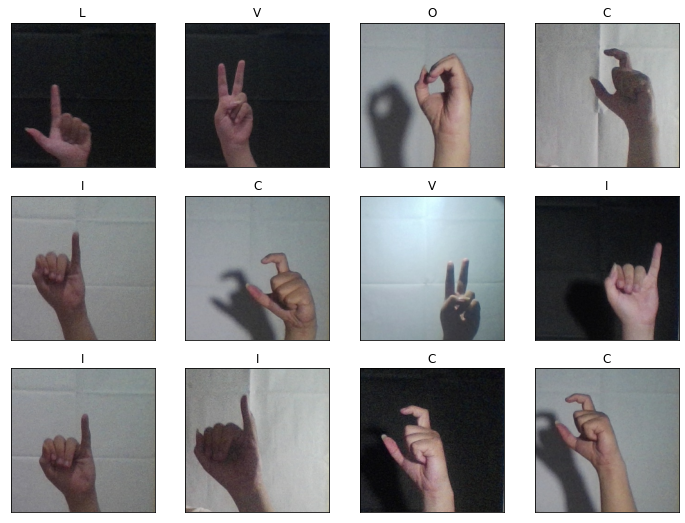

In [15]:
view_image(ds_train, CLASS_LABELS)

Membuat fungsi augmentasi

In [16]:
def augment(image, label):
    if tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32) < 1:
        if tf.random.uniform((), minval=0, maxval=3, dtype=tf.int32) < 2:
            image= tf.image.random_saturation(image, lower=0.5, upper= 2.5)
        else:
            image= tf.tile(tf.image.rgb_to_grayscale(image),[1,1,1,3])

    if tf.random.uniform((), minval=0, maxval=5, dtype=tf.int32) < 1:
        if tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32) < 1:
            image= tf.image.resize(image, (tf.random.uniform((), minval=RESIZED_IMAGE_SIZE[0]//8*5, maxval= RESIZED_IMAGE_SIZE[0]-10, dtype=tf.int32), RESIZED_IMAGE_SIZE[1]))
        else:
            image= tf.image.resize(image, (RESIZED_IMAGE_SIZE[0], tf.random.uniform((), minval=RESIZED_IMAGE_SIZE[1]//8*5, maxval=RESIZED_IMAGE_SIZE[1]-10, dtype=tf.int32)))
        
        image= tf.image.resize_with_pad(image, RESIZED_IMAGE_SIZE[0], RESIZED_IMAGE_SIZE[1])
    
    if tf.random.uniform((), minval=0, maxval=3, dtype=tf.int32) < 1:
        image= tfa.image.rotate(image, tf.random.uniform((), minval=-0.8, maxval=0.8, dtype=tf.float32), fill_mode='nearest')

    image = tf.image.random_flip_left_right(image)
    image= tf.clip_by_value(image, 0, 1)

    return image, label

Mengaplikasikan data pipeline pada `ds_train` dan `ds_val`

In [17]:
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE).shuffle(32).cache('/').prefetch(AUTOTUNE)
ds_val= ds_val.cache('/').prefetch(AUTOTUNE)

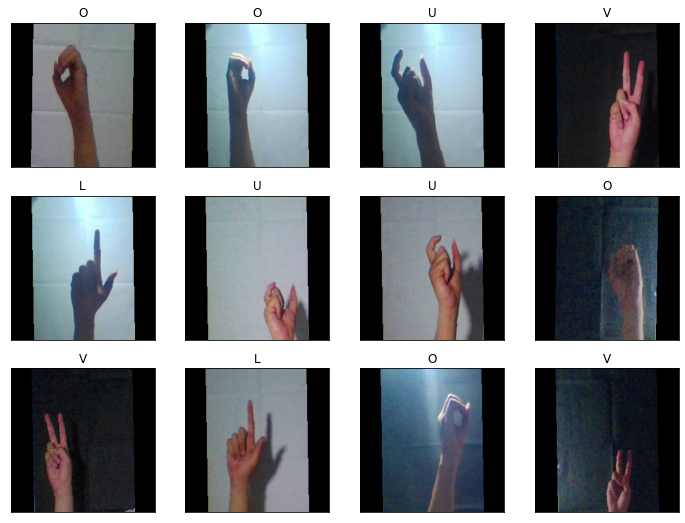

In [18]:
view_image(ds_train, CLASS_LABELS)

# Modeling

Me-load model pre-trained ResNet50V2 tanpa top

In [19]:
base_model = keras.applications.ResNet50V2(
    input_shape=RESIZED_IMAGE_SHAPE,
    include_top=False, 
    pooling='max',
    weights = "imagenet"
)

94683136/94668760 [==============================] - 0s 0us/step


Membuat model, tapi terlebih dahulu dilakukan freeze pada `base_model`

In [20]:
base_model.trainable= False
model= keras.models.Sequential()
model.add(base_model)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(CLASS_LABELS), 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [21]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'] 
)

In [22]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.5, patience=0, min_lr=1e-5, min_delta=0.01)

history = model.fit(ds_train, epochs=5, validation_data=ds_val, batch_size=BATCH_SIZE, callbacks=[reduce_lr])

Epoch 1/5
189/189 [==============================] - 61s 228ms/step - loss: 3.6751 - accuracy: 0.6207 - val_loss: 0.7948 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 2/5
189/189 [==============================] - 21s 108ms/step - loss: 1.2963 - accuracy: 0.8205 - val_loss: 0.5872 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 3/5
189/189 [==============================] - 20s 108ms/step - loss: 0.8986 - accuracy: 0.8685 - val_loss: 0.3912 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 4/5
189/189 [==============================] - 21s 109ms/step - loss: 0.7693 - accuracy: 0.8776 - val_loss: 0.2847 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 5/5
189/189 [==============================] - 21s 111ms/step - loss: 0.5181 - accuracy: 0.9078 - val_loss: 0.2253 - val_accuracy: 0.9525 - lr: 5.0000e-04


Fine-tuning

In [23]:
base_model.trainable= True

for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable= False

optimizer= keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer= optimizer,
    loss= 'sparse_categorical_crossentropy',
    metrics= ['accuracy']
)

In [24]:
ft_history= model.fit(ds_train, epochs=2, validation_data=ds_val, callbacks=[reduce_lr])

Epoch 1/2
189/189 [==============================] - 68s 325ms/step - loss: 0.4105 - accuracy: 0.9225 - val_loss: 0.0992 - val_accuracy: 0.9701 - lr: 1.0000e-05
Epoch 2/2
189/189 [==============================] - 60s 317ms/step - loss: 0.1437 - accuracy: 0.9643 - val_loss: 0.0319 - val_accuracy: 0.9896 - lr: 1.0000e-05


Plot loss dan akurasi training

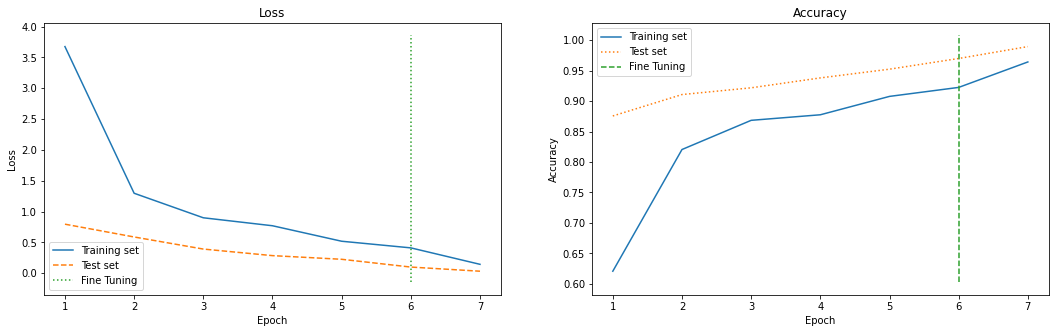

In [25]:
loss = history.history['loss'] + ft_history.history['loss']
val_loss = history.history['val_loss'] + ft_history.history['val_loss']

accuracy = history.history['accuracy'] + ft_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + ft_history.history['val_accuracy']

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(7)), list(range(1,8)))
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot([5, 5], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(7)), list(range(1,8)))
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='dotted')
plt.plot([5, 5], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

# Evaluasi

Untuk evaluasi, akan digunakan pada data baru yang dibuat secara pribadi.

In [29]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [52]:
!unzip -q "/content/gdrive/MyDrive/Datasets/bisindo_test.zip" -d "/content/bisindo_test"

In [53]:
ds_test= keras.utils.image_dataset_from_directory(
    directory= '/content/bisindo_test/bisindo_test', 
    batch_size= BATCH_SIZE,
    image_size= RESIZED_IMAGE_SIZE,
    shuffle= True,
    seed= 1,
    labels='inferred',
)

ds_test= ds_test.map(normalize)

Found 17 files belonging to 6 classes.


In [56]:
model.evaluate(ds_test)

1/1 [==============================] - 1s 1s/step - loss: 0.2910 - accuracy: 0.9412


[0.29102638363838196, 0.9411764740943909]

In [66]:
def view_image_and_predict(ds, class_labels=None, num_plot=(6,3), figsize=None):
    data = next(iter(ds))
    image = data[0].numpy()
    label = data[1].numpy()
    
    if figsize is None:
        figsize= (num_plot[1]*3, num_plot[0]*3)

    fig = plt.figure(figsize=figsize)

    for i in range(num_plot[0]*num_plot[1]):
        try:
            ax = fig.add_subplot(num_plot[0], num_plot[1], i+1, xticks=[], yticks=[])
            ax.imshow(image[i])

            predicted= np.argmax(model.predict(tf.expand_dims(image[i], 0)))
            is_correct= 'correct' if predicted==label[i] else 'incorrect'
            ax.set_title(f'predict: {class_labels[int(predicted)]}, true: {class_labels[label[i]]}')
        except:
            pass

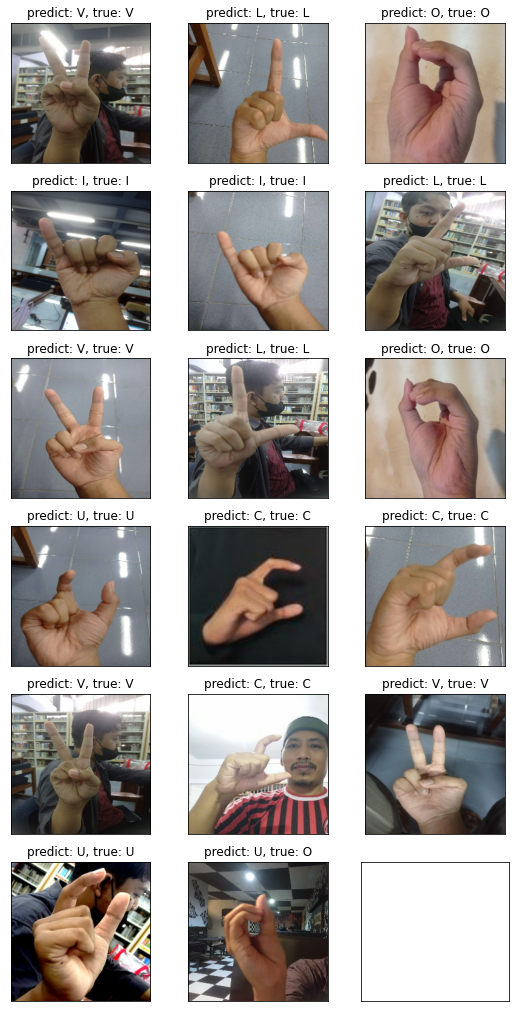

In [67]:
view_image_and_predict(ds_test, CLASS_LABELS)